In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch as t
import torch.nn as nn
from pathlib import Path
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from DiagnosisAI.models.AutoEncoder_UNET.AutoEncoder_BRAIN_UNET import UNet
from DiagnosisAI.utils.utils_function import crop_mask_to_segment, transform_to_metrics
import torchmetrics

from torchvision.transforms import Compose, ToTensor
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
# import cv2 as cv

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class BrainSlicesDataset(t.utils.data.Dataset):
    def __init__(self, file_names: list, transform: bool = True, binary_mask: bool = True):
        self.root_path = Path("../datasets/brain/train_images_max_area/")
        self.file_names = file_names
        self.image_size = (240, 240)
        self.transform = transform
        self.binary_mask = binary_mask
        self.transforms = Compose([ToTensor()])

    def __getitem__(self, idx):
        slice_pickle_path = self.root_path / self.file_names[idx]
        with open(slice_pickle_path, 'rb') as handle:
            slice_data = pickle.load(handle)
        img_flair = slice_data['flair'].astype(np.float32).squeeze()
        img_t1 = slice_data['t1'].astype(np.float32).squeeze()
        img_t1ce = slice_data['t1ce'].astype(np.float32).squeeze()
        img_t2 = slice_data['t2'].astype(np.float32).squeeze()
        img = np.stack([img_flair, img_t1, img_t1ce, img_t2], axis=2)
        label = slice_data['seg']
        label = np.stack([label, label, label, label], axis=2)
        # convert to binary mask
        if self.binary_mask:
            label = np.where(label >= 1, 1, 0)

        if self.transform:
            img = self.transforms(img)
            label = self.transforms(label)
            if self.binary_mask:
                label = label.type(t.float32)

        return img, label

    def __len__(self):
        return len(self.file_names)

In [6]:
filenames_pickle = []
for dir in Path("../datasets/brain/train_images_max_area/").iterdir():
    for filename in dir.iterdir():
        rel_path = Path(*filename.parts[-2:])
        filenames_pickle.append(rel_path)

In [7]:
train_names, val_names = train_test_split(filenames_pickle, test_size=0.2, random_state=42)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=42)

In [8]:
train_dataset = BrainSlicesDataset(train_names)
val_dataset = BrainSlicesDataset(val_names)
test_dataset = BrainSlicesDataset(test_names)

In [9]:
batch_size = 8

In [10]:
train_loader = t.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
val_loader = t.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = t.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [11]:
device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

In [12]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = UNet(in_channels=4, out_channels=4, n_filters=16)
        # self.loss_function = nn.CrossEntropyLoss() for semantic
        self.loss_function = nn.BCEWithLogitsLoss() # for binary 
        metrics = torchmetrics.MetricCollection([torchmetrics.Precision(num_classes=1, average='macro', mdmc_average='samplewise'),
                                                 torchmetrics.Recall(num_classes=1, average='macro', mdmc_average='samplewise'),
                                                 torchmetrics.F1Score(num_classes=1, average='macro', mdmc_average='samplewise'),
                                                 torchmetrics.Accuracy(num_classes=1, average='macro', mdmc_average='samplewise'),
                                                 torchmetrics.JaccardIndex(num_classes=2)
                                                ])
        self.train_metrics = metrics.clone('train_')
        self.val_metrics = metrics.clone('val_')

    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        outputs = nn.Sigmoid()(outputs)
        loss = self.loss_function(outputs, labels)
        self.log('train_loss', loss)
        self.log_dict(self.train_metrics(outputs.view(-1), labels.type(t.int32).view(-1)))
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        outputs = nn.Sigmoid()(outputs)
        loss = self.loss_function(outputs, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log_dict(self.val_metrics(outputs.view(-1), labels.type(t.int32).view(-1)))

    def configure_optimizers(self):
        return t.optim.Adam(self.parameters(), lr=1e-3)

In [13]:
f = open('../config/secret.json')
api_key = json.load(f)

In [14]:
segmenter = Segmenter()

model_checkpoint = pl.callbacks.ModelCheckpoint(dirpath='../src/DiagnosisAI/models/AutoEncoder_UNET/checkpoints')
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
logger = pl.loggers.NeptuneLogger(
    api_key=api_key['api_neptune'],
    project="jumpincrane/Binary-slices"
)

In [317]:
trainer = pl.Trainer(logger=logger, callbacks=[model_checkpoint, early_stopping], gpus=1, max_epochs=100)
trainer.fit(segmenter, train_dataloaders=train_loader, val_dataloaders=val_loader)

logger.run.stop()
t.save(segmenter.state_dict(), "../src/DiagnosisAI/models/AutoEncoder_UNET/binary_state_brats_train")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | network       | UNet              | 2.2 M 
1 | loss_function | BCEWithLogitsLoss | 0     
2 | train_metrics | MetricCollection  | 0     
3 | val_metrics   | MetricCollection  | 0     
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.641     Total estimated model params size (MB)
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /mnt/e/mgr/src/DiagnosisAI/models/AutoEncoder_UNET/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Epoch 0:  35%|███▌      | 50/141 [00:15<00:27,  3.26it/s, loss=0.888] https://app.neptune.ai/jumpincrane/Binary-slices/e/BIN-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 39:  31%|███       | 44/141 [00:13<00:29,  3.29it/s, loss=0.68, v_num=IN-9, val_loss=0.693]  Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 43 operations to synchronize with Neptune. Do not kill this process.


/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


All 43 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jumpincrane/Binary-slices/e/BIN-9


In [15]:
segmenter = segmenter.load_from_checkpoint("/mnt/e/mgr/src/DiagnosisAI/models/AutoEncoder_UNET/checkpoints/epoch=38-step=4874.ckpt").to(device)
segmenter = segmenter.eval()

In [16]:
img, label = test_dataset[17]
img = img[np.newaxis, :, :]
label = label[0]

In [17]:
with t.no_grad():
    prediction = segmenter(img.to(device)).cpu()
output = nn.Sigmoid()(prediction).squeeze()
# output = np.where(output >= 0.1, 1, 0)

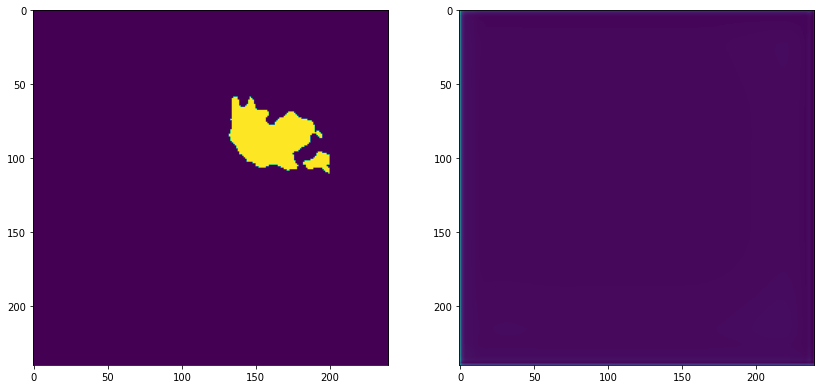

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 10))
ax[0].imshow(label)
ax[1].imshow(output[3])

In [305]:
masked_output, masked_label = crop_mask_to_segment(output, label)
output_m, label_m = transform_to_metrics(output, label)

In [205]:
output_m.unsqueeze(dim=0).shape

torch.Size([1, 240, 240])